    Run `python make_pooled_datasets.py configs/3T_NIST_T1maps.json 3T_NIST_T1maps` first

In [1]:
from pathlib import Path
import pandas as pd
import json
import nibabel as nib
import numpy as np

In [2]:
data_folder_name = '3T_human_T1maps'
output_filename = '3T_human_T1maps_database'

In [3]:
configFile = Path('configs/3T_human_T1maps.json')

In [4]:
with open(configFile) as json_file:
    configJson = json.load(json_file)

In [5]:
def create_database(configJson):
    columns = [
    'id',
    'OSF dataset', 'OSF link', 'NIFTI filename', 'Data type',
    'contact',
    'site name', 'MRI vendor', 'MRI version', 'MRI field',
    'sample type',
    'phantom version', 'phantom serial number', 'phantom temperature',
    'age', 'sex',
    'sequence name', 'sequence type', 'matrix size', 'resolution', 'dimension', 'TR', 'echo time', 'TI', 'bandwidth',
    'T1 - genu (WM)', 'T1 - splenium (WM)', 'T1 - deep GM', 'T1 - cortical GM'
    ]

    df = pd.DataFrame(columns=columns)
    df = df.set_index('id')
    
    df = parse_dataset_json(df, configJson)
    
    return df

In [6]:
def parse_dataset_json(df, configJson):

    id = 1
    subid = 1

    for dataset_name in configJson:
        db_id = id+subid*0.001
        for key1 in configJson[dataset_name]:
            if key1 == 'datasets':
                for key2 in configJson[dataset_name][key1]:
                    db_id = id+subid*0.001
                    subid = subid+1

                    dataset_series = {
                        'OSF dataset': dataset_name,
                        'OSF link': configJson[dataset_name]['OSF_link'],
                        'NIFTI filename': configJson[dataset_name]['datasets'][key2]['imagePath'],
                        'Data type': configJson[dataset_name]['datasets'][key2]['dataType']
                    }
                    
                    t1File = configJson[dataset_name]['datasets'][key2]['imagePath']
                    t1JsonFile = data_folder_name / Path(t1File[:-7] + '.json')
                    
                    with open(t1JsonFile) as json_file:
                        t1Json = json.load(json_file)

                    dataset_series = parse_t1_json(dataset_series, t1Json)
                    dataset_series = parse_rois(dataset_series, t1File, data_folder_name, t1Json['sample']['type'])
                    
                    df = df.append(pd.Series(dataset_series, index = df.columns, name = db_id))
        # Increment dataset ID counter
        id = id + 1
    
        # Reset subdataset ID counter
        subid = 1
    return df

In [7]:
def parse_t1_json(dataset_series, t1Json):
    dataset_series.update({
        'contact': t1Json['submitter']['contact'],
    })

    dataset_series.update({
        'site name': t1Json['site']['name'],
        'MRI vendor': t1Json['site']['manufacturer'],
        'MRI version': t1Json['site']['version'],
        'MRI field': t1Json['site']['field'],
    })
    
    if 'temperature' in t1Json['sample']:
        temp = t1Json['sample']['temperature']
    else:
        temp = None
    
    if t1Json['sample']['type'] is 'NIST':
        dataset_series.update({
            'sample type': t1Json['sample']['type'],
            'phantom version': t1Json['sample']['version'],
            'phantom serial number': t1Json['sample']['serial_number'],
            'phantom temperature': temp,
        })
        dataset_series.update({
            'age': None,
            'sex': None,
        })
    else:
        dataset_series.update({
            'sample type': 'Human',
            'age': t1Json['sample']['age'],
            'sex': t1Json['sample']['sex'],
        })
        dataset_series.update({
            'sample type': None,
            'phantom version': None,
            'phantom serial number': None,
            'phantom temperature': None,
        })


    if 'bandwidth' in t1Json['sequence']:
        bandwidth = t1Json['sequence']['bandwidth']
    else:
        bandwidth = None

    dataset_series.update({
        'sequence name': t1Json['sequence']['name'],
        'sequence type': t1Json['sequence']['type'],
        'matrix size': t1Json['sequence']['matrix_size'],
        'resolution': t1Json['sequence']['resolution'],
        'dimension': t1Json['sequence']['dimension'],
        'TR': t1Json['sequence']['repetition_time'],
        'echo time': t1Json['sequence']['echo_time'],
        'TI': t1Json['sequence']['inversion_times'],    
        'bandwidth': bandwidth,        
    })
    return dataset_series

In [8]:
def parse_rois(dataset_series, t1File, data_folder_name, sample_type):
    
    if 't1map' in str(t1File):
        roiFile = str(t1File)
        roiFile = roiFile.replace('t1map', 'rois')
    else:
        roiFile = t1File
        roiFile = roiFile.replace('T1map', 'rois')
    
    t1Path = Path(data_folder_name) / t1File
    roiPath = Path(data_folder_name) / roiFile 

    t1 = nib.load(t1Path)
    roi = nib.load(roiPath)
    
    t1_data = t1.get_fdata()
    roi_data = roi.get_fdata()

    if sample_type is 'NIST':
        dataset_series.update({
            'T1 - genu (WM)': None,
            'T1 - splenium (WM)': None,
            'T1 - deep GM': None,
            'T1 - cortical GM': None,
        })
    else:
        roi_1_indexes=np.where(np.isclose(np.squeeze(roi_data),1,atol=0.01))
        roi_2_indexes=np.where(np.isclose(np.squeeze(roi_data),2,atol=0.01))
        roi_3_indexes=np.where(np.isclose(np.squeeze(roi_data),3,atol=0.01))
        roi_4_indexes=np.where(np.isclose(np.squeeze(roi_data),4,atol=0.01))

        dataset_series.update({
            'T1 - genu (WM)': t1_data[roi_1_indexes],
            'T1 - splenium (WM)': t1_data[roi_2_indexes],
            'T1 - deep GM': t1_data[roi_3_indexes],
            'T1 - cortical GM': t1_data[roi_4_indexes],
        })
        print(t1Path)
        print(np.mean(t1_data[roi_1_indexes]))
        print(np.std(t1_data[roi_1_indexes]))
        print(np.mean(t1_data[roi_2_indexes]))
        print(np.std(t1_data[roi_2_indexes]))
        print(np.mean(t1_data[roi_3_indexes]))
        print(np.std(t1_data[roi_3_indexes]))
        print(np.mean(t1_data[roi_4_indexes]))
        print(np.std(t1_data[roi_4_indexes]))


    return dataset_series

In [9]:
df = create_database(configJson)

3T_human_T1maps/20200103_refaatgabr_mcgovern_human/20200103_refaatgabr_mcgovern_human_t1map.nii.gz
1249.2359999999999
81.77300229293286
1284.248
44.61989798285065
nan
nan
2549.151851851852
375.929349519167
3T_human_T1maps/20200128_mrel_usc_human/20200128_mrel_usc_GE3T_MR1_human_subject01_t1map.nii.gz
850.712
60.563476254257395
900.1720000000001
97.71793088271977
1204.348
118.75523439410998
1391.0333333333333
77.59133208558039
3T_human_T1maps/20200128_mrel_usc_human/20200128_mrel_usc_GE3T_MR1_human_subject02_t1map.nii.gz
870.8149999999999
50.06036630908727
872.0750000000002
38.41968082897098
1256.17
49.533454351579394
1433.1166666666666
105.3838763231306
3T_human_T1maps/20200128_mrel_usc_human/20200128_mrel_usc_GE3T_MR1_human_subject03_t1map.nii.gz
886.9559999999999
46.50443488528809
881.988
34.37662368528939
953.3839999999999
43.889695191468356
1416.7962962962963
93.96170804575218
3T_human_T1maps/20200128_mrel_usc_human/20200206_mrel_usc_GE3T_MR1_human_subject04_t1map.nii.gz
960.279999

/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / r

3T_human_T1maps/20200128_mrel_usc_human/20200228_mrel_usc_GE3T_MR2_human_subject05_t1map.nii.gz
830.068
100.26768061544057
890.168
42.58451098697741
1285.32
108.78544020226235
1571.4037037037037
116.94278588894556
3T_human_T1maps/20200128_mrel_usc_human/20200228_mrel_usc_GE3T_MR2_human_subject06_t1map.nii.gz
784.28
90.57719359750554
880.8679999999999
43.62867607434358
1150.0
50.076086109040126
1381.562962962963
205.6184350939383
3T_human_T1maps/20200203_iveslevesque_muhc_mgh_human/20200203_iveslevesque_muhc_mgh_human_t1map.nii.gz
913.6
159.53027549653387
1101.8200000000002
86.15686623827493
1847.4375
214.10633127899322
2177.9
454.7742647202586
3T_human_T1maps/20200203_siyuanhu_casewestern_human/20200203_siyuanhu_casewestern_human_t1map.nii.gz
811.112
25.050306505110864
862.1720000000001
50.08705637188115
1200.248
55.88450318290395
1516.5814814814817
132.0966706537497
3T_human_T1maps/20200207_jorgejovicich_cimec_human/subject_1/20200207_jorgejovicich_cimec_human_sub1_20ch_t1map.nii.gz
8

827.068
22.70268213229442
1346.496
49.9158209789241
1858.3925925925928
146.55130545414974
3T_human_T1maps/20200225_luisconcha_UNAM_human/session_1/56347/20200223_155637_GE/56347_GE_raw_IRData_t1map.nii.gz
847.2359999999999
19.01477067965848
872.3720000000001
20.080866913557283
1184.5119999999997
44.16637019271561
1497.8
99.69238241265533
3T_human_T1maps/20200225_luisconcha_UNAM_human/session_1/56347/20200223_155637_GE/56347_GE_filtered_IRData_t1map.nii.gz
851.4599999999998
14.187036336035789
875.076
11.698659068457369
1192.48
27.950313057280745
1492.0148148148146
81.14677467269122
3T_human_T1maps/20200225_luisconcha_UNAM_human/session_1/56347/20200223_152800_Ph/56347_Ph_mag_IRData_t1map.nii.gz
829.5
22.061096980884695
847.075
20.94057962426064
1185.685
29.771450670063093
1673.111111111111
88.0735418013384
3T_human_T1maps/20200225_luisconcha_UNAM_human/session_1/58415/20200223_134934_Ph/58415_Ph_mag_IRData_t1map.nii.gz
822.7079999999999
29.071455691107055
799.0520000000001
30.6497519728

In [10]:
df

,OSF dataset,OSF link,NIFTI filename,Data type,contact,site name,MRI vendor,MRI version,MRI field,sample type,...,resolution,dimension,TR,echo time,TI,bandwidth,T1 - genu (WM),T1 - splenium (WM),T1 - deep GM,T1 - cortical GM
id,,,,,,,,,,,,,,,,,,,,,
1.001,refaatgabr_mcgovern_human,https://osf.io/2f8j5/download/,20200103_refaatgabr_mcgovern_human/20200103_re...,Magnitude,Refaat Gabr,UTHealth McGovern Medical School,Philips,Ingenia R5.4.1,3.0,None,...,[1 1 2],2D,2560.0,14.00,"[50, 400, 1100, 2500]",173.8,"[1306.3, 1195.7, 1258.8, 1389.5, 1484.2, 1217....","[1283.8, 1308.3, 1358.2, 1352.2, 1299.9, 1303....",[],"[4074.4, 2741.4, 2492.2, 2785.8, 2123.1, 1952...."
2.001,mrel_usc_human,https://osf.io/z8dyw/download/,20200128_mrel_usc_human/20200128_mrel_usc_GE3T...,Magnitude,Nam Lee,Keck Medical Center of University of Southern ...,GE,Signa HDxt,3.0,None,...,[0.75 0.75 2],2D,2550.0,14.00,"[50, 400, 1100, 2500]",244.141,"[736.6, 783.5, 860.1, 830.2, 704.2, 699.8, 851...","[870.3, 810.2, 875.1, 765.6, 761.0, 912.1, 845...","[1007.1, 990.0, 1046.1, 1162.1, 1266.9, 972.6,...","[1388.8, 1339.2, 1252.8, 1388.0, 1348.9, 1417...."
2.002,mrel_usc_human,https://osf.io/z8dyw/download/,20200128_mrel_usc_human/20200128_mrel_usc_GE3T...,Magnitude,Nam Lee,Keck Medical Center of University of Southern ...,GE,Signa HDxt,3.0,None,...,[0.875 0.875 2],2D,2550.0,14.00,"[50, 400, 1100, 2500]",244.141,"[938.9, 864.1, 725.2, 889.8, 869.5, 844.9, 879...","[877.0, 923.1, 929.9, 890.7, 774.1, 894.6, 899...","[1207.2, 1219.8, 1256.3, 1169.3, 1164.7, 1214....","[1417.7, 1550.6, 1358.5, 1407.2, 1584.8, 1547...."
2.003,mrel_usc_human,https://osf.io/z8dyw/download/,20200128_mrel_usc_human/20200128_mrel_usc_GE3T...,Magnitude,Nam Lee,Keck Medical Center of University of Southern ...,GE,Signa HDxt,3.0,None,...,[1 1 2],2D,2550.0,14.00,"[50, 400, 1100, 2500]",244.141,"[921.2, 895.9, 874.6, 766.1, 855.0, 902.2, 901...","[908.1, 941.9, 944.4, 901.1, 850.8, 870.6, 887...","[1020.7, 952.4, 1007.4, 1003.5, 860.8, 1029.3,...","[1295.1, 1315.4, 1381.0, 1353.8, 1369.4, 1451...."
2.004,mrel_usc_human,https://osf.io/z8dyw/download/,20200128_mrel_usc_human/20200206_mrel_usc_GE3T...,Magnitude,Nam Lee,Keck Medical Center of University of Southern ...,GE,Signa HDxt,3.0,None,...,[1 1 2],2D,2550.0,14.00,"[50, 400, 1100, 2500]",244.141,"[954.1, 910.8, 930.4, 893.6, 926.1, 854.4, 914...","[972.3, 922.2, 963.2, 927.0, 908.9, 1045.4, 90...","[1431.7, 1392.1, 1435.7, 1384.8, 1255.9, 1371....",[]
2.005,mrel_usc_human,https://osf.io/z8dyw/download/,20200128_mrel_usc_human/20200228_mrel_usc_GE3T...,Magnitude,Nam Lee,Keck Medical Center of University of Southern ...,GE,Signa HDxt,3.0,None,...,[1 1 2],2D,2550.0,14.00,"[50, 400, 1100, 2500]",244.141,"[720.6, 803.1, 755.7, 716.7, 877.2, 778.1, 787...","[830.3, 857.9, 929.6, 942.5, 958.8, 871.6, 819...","[1136.2, 1170.0, 1191.7, 1361.5, 1389.9, 1256....","[1492.6, 1511.7, 1622.5, 1666.9, 1767.3, 1607...."
2.006,mrel_usc_human,https://osf.io/z8dyw/download/,20200128_mrel_usc_human/20200228_mrel_usc_GE3T...,Magnitude,Nam Lee,Keck Medical Center of University of Southern ...,GE,Signa HDxt,3.0,None,...,[1 1 2],2D,2550.0,14.00,"[50, 400, 1100, 2500]",244.141,"[767.3, 696.0, 657.9, 691.9, 693.6, 784.0, 750...","[915.1, 871.1, 862.5, 872.4, 897.6, 882.9, 812...","[1186.0, 1151.6, 1107.9, 1190.4, 1149.1, 1136....","[1518.9, 1603.7, 1632.2, 1463.3, 1665.5, 1636...."
3.001,iveslevesque_muhc_mgh_human,https://osf.io/n9edp/download/,20200203_iveslevesque_muhc_mgh_human/20200203_...,Magnitude,Ives Levesque,McGill University Health Centre - Montreal Gen...,Siemens,syngo MR E11,3.0,None,...,[1 1 2],2D,2550.0,14.00,"[50, 400, 1100, 2500]",390,"[756.0, 735.2, 753.1, 788.2, 1109.1, 762.3, 77...","[1120.0, 1055.3, 1135.0, 1114.3, 1126.7, 1216....","[1845.5, 1919.8, 1869.6, 2002.4, 2129.2, 1869....","[2395.6, 2375.9, 2318.3, 3436.2, 2755.3, 2515...."
4.001,siyuanhu_casewestern_human,https://osf.io/jrzg6/download/,20200203_siyuanhu_casewestern_human/20200203_s...,Magnit

In [11]:
df.to_excel(output_filename + ".xlsx")  

In [12]:
df.loc[1.001]

OSF dataset                                      refaatgabr_mcgovern_human
OSF link                                    https://osf.io/2f8j5/download/
NIFTI filename           20200103_refaatgabr_mcgovern_human/20200103_re...
Data type                                                        Magnitude
contact                                                        Refaat Gabr
site name                                 UTHealth McGovern Medical School
MRI vendor                                                         Philips
MRI version                                                 Ingenia R5.4.1
MRI field                                                                3
sample type                                                           None
phantom version                                                       None
phantom serial number                                                 None
phantom temperature                                                   None
age                      

In [13]:
df.loc[1.001]['T1 - genu (WM)']

array([1306.3, 1195.7, 1258.8, 1389.5, 1484.2, 1217.3, 1236.7, 1223.9,
       1314.8, 1347. , 1210.2, 1220.4, 1250.9, 1177.3, 1136.7, 1212.8,
       1193.6, 1268.3, 1199.9, 1099.1, 1225.8, 1282.4, 1344.7, 1279.1,
       1155.5])

In [14]:
genu_mean = np.array([])
genu_std = np.array([])
splenium_mean = np.array([])
splenium_std = np.array([])
deepgm_mean = np.array([])
deepgm_std = np.array([])
cgm_mean = np.array([])
cgm_std = np.array([])

ii = 0
for index, row in df.iterrows():
    genu_mean = np.append(genu_mean, np.mean(df.loc[index]['T1 - genu (WM)']))
    genu_std = np.append(genu_std, np.std(df.loc[index]['T1 - genu (WM)']))
    splenium_mean = np.append(splenium_mean, np.mean(df.loc[index]['T1 - splenium (WM)']))
    splenium_std = np.append(splenium_std, np.std(df.loc[index]['T1 - splenium (WM)']))
    deepgm_mean = np.append(deepgm_mean, np.mean(df.loc[index]['T1 - deep GM']))
    deepgm_std = np.append(deepgm_std, np.std(df.loc[index]['T1 - deep GM']))
    cgm_mean = np.append(cgm_mean, np.mean(df.loc[index]['T1 - cortical GM']))
    cgm_std = np.append(cgm_std, np.std(df.loc[index]['T1 - cortical GM']))
    ii = ii +1

/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/mathieuboudreau/opt/anaconda3/envs/rrsg_analysis/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / r

In [15]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)
indexes = df.index

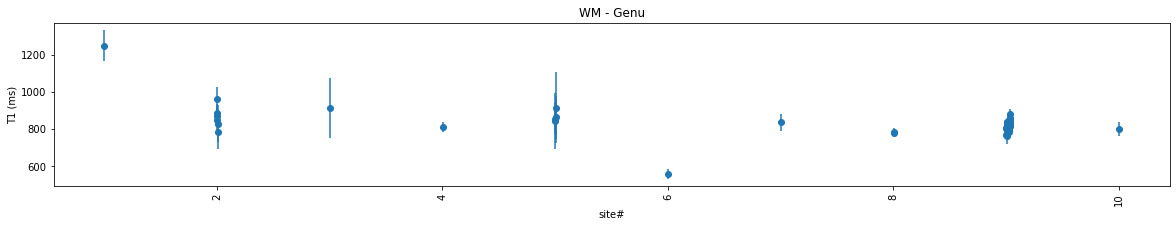

In [27]:
plt.errorbar(indexes,genu_mean, genu_std, fmt='o')
plt.xticks(rotation=90)
plt.title('WM - Genu')
plt.ylabel('T1 (ms)')
plt.xlabel('site#')
plt.show()

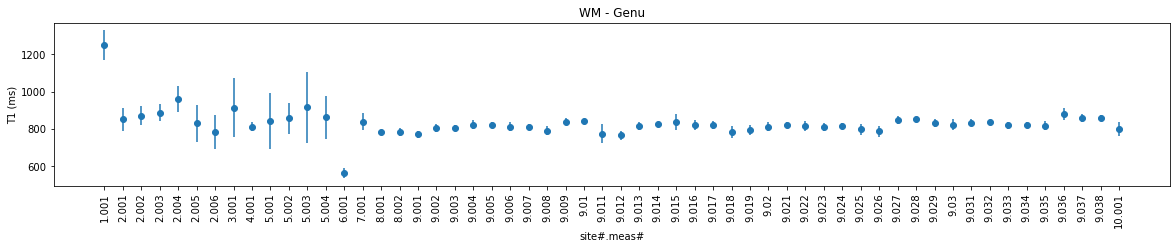

In [28]:
plt.errorbar(indexes.map(str),genu_mean, genu_std, fmt='o')
plt.xticks(rotation=90)
plt.title('WM - Genu')
plt.ylabel('T1 (ms)')
plt.xlabel('site#.meas#')
plt.show()

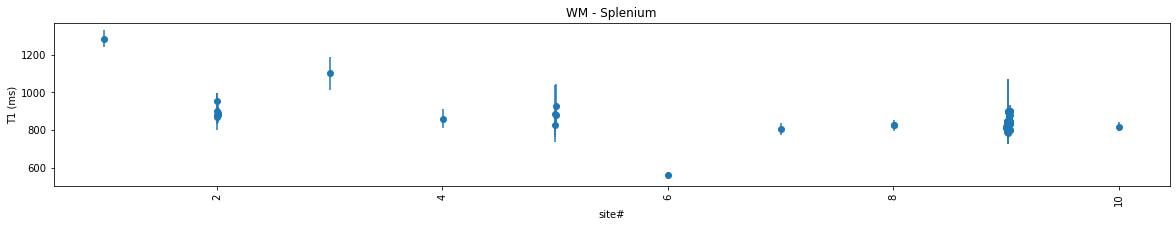

In [29]:
plt.errorbar(indexes,splenium_mean, splenium_std, fmt='o')
plt.xticks(rotation=90)
plt.title('WM - Splenium')
plt.ylabel('T1 (ms)')
plt.xlabel('site#')
plt.show()

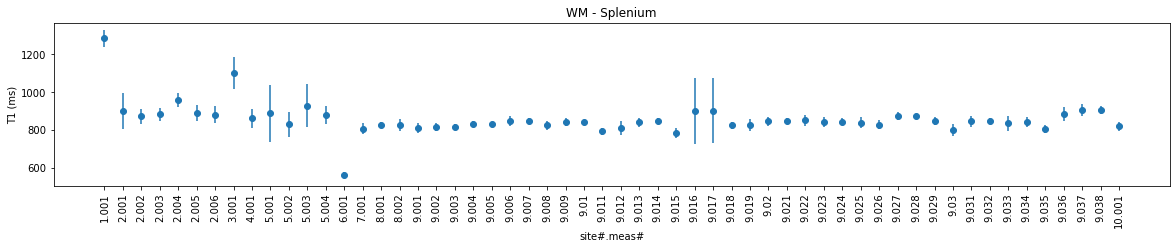

In [30]:
plt.errorbar(indexes.map(str),splenium_mean, splenium_std, fmt='o')
plt.xticks(rotation=90)
plt.title('WM - Splenium')
plt.ylabel('T1 (ms)')
plt.xlabel('site#.meas#')
plt.show()

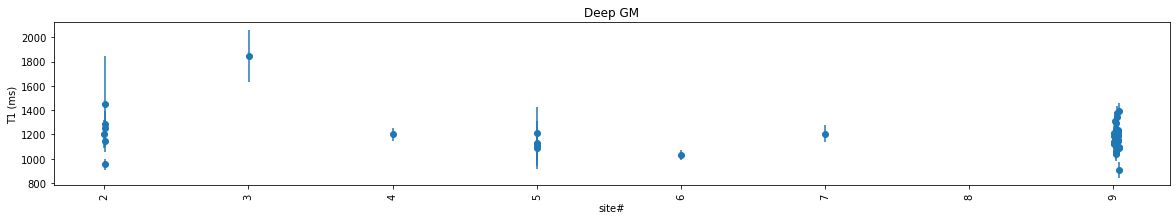

In [31]:
plt.errorbar(indexes,deepgm_mean, deepgm_std, fmt='o')
plt.xticks(rotation=90)
plt.title('Deep GM')
plt.ylabel('T1 (ms)')
plt.xlabel('site#')
plt.show()

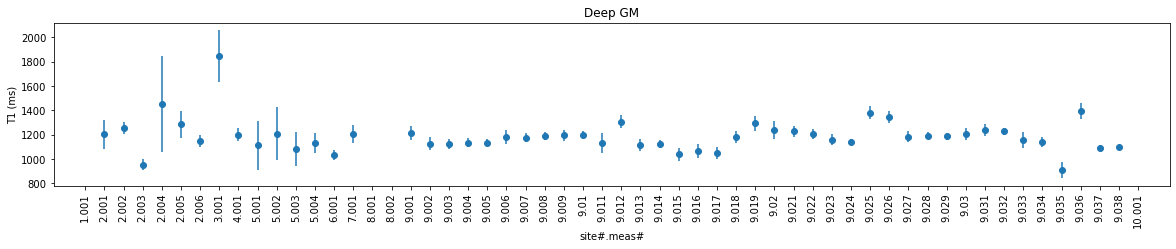

In [32]:
plt.errorbar(indexes.map(str),deepgm_mean, deepgm_std, fmt='o')
plt.xticks(rotation=90)
plt.title('Deep GM')
plt.ylabel('T1 (ms)')
plt.xlabel('site#.meas#')
plt.show()

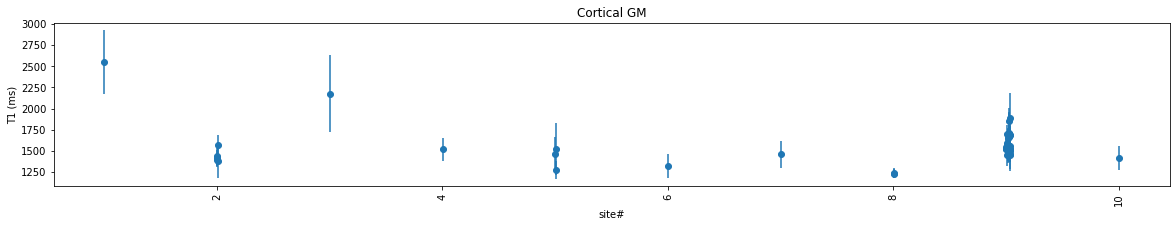

In [33]:
plt.errorbar(indexes,cgm_mean, cgm_std, fmt='o')
plt.xticks(rotation=90)
plt.title('Cortical GM')
plt.ylabel('T1 (ms)')
plt.xlabel('site#')
plt.show()

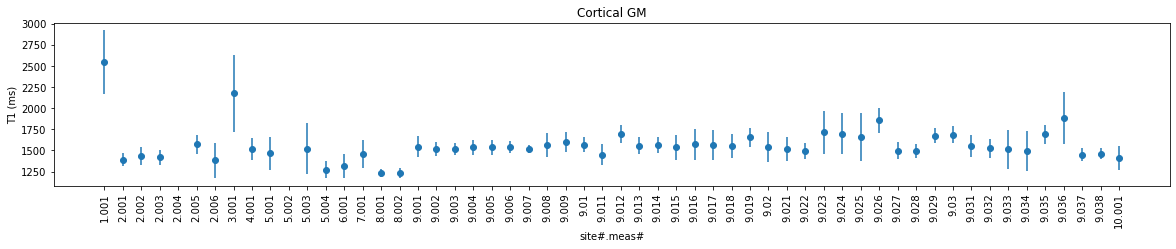

In [34]:
plt.errorbar(indexes.map(str),cgm_mean, cgm_std, fmt='o')
plt.xticks(rotation=90)
plt.title('Cortical GM')
plt.ylabel('T1 (ms)')
plt.xlabel('site#.meas#')
plt.show()